### Customer churn with Logistic Regression
A telecommunications company is concerned about the number of customers leaving their land-line business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

In [1]:
# import required libraries

import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

### About dataset
1. Here we use a telecommunications data for predicting customer churn. 
2. This is a historical customer data where each row represents one customer. 
3. Typically this data is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company. 

This data set provides info to help you predict behavior to retain customers. We can analyze all relevant customer data and develop focused customer retention programs.


The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


In [2]:
# Load data
churn_df = pd.read_csv("ChurnData.csv")
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


In [3]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

Lets select some features for the modeling. Also we change the target data type to be integer, as it is a requirement  by the skitlearn algorithm:

In [4]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


In [5]:
churn_df.shape

(200, 10)

### EDA

#### Data Exploration

In [6]:
# Statistical data information
churn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,200.0,35.505,21.640971,1.0,16.75,33.5,55.25,72.0
age,200.0,41.165,13.076803,19.0,31.00,40.0,51.00,76.0
address,200.0,11.650,10.158419,0.0,3.00,9.0,18.00,48.0
income,200.0,75.130,128.430468,9.0,31.00,48.0,80.00,1668.0
ed,200.0,2.825,1.285550,1.0,2.00,3.0,4.00,5.0
employ,200.0,10.225,8.957430,0.0,3.00,7.5,17.00,44.0
equip,200.0,0.425,0.495584,0.0,0.00,0.0,1.00,1.0
callcard,200.0,0.705,0.457187,0.0,0.00,1.0,1.00,1.0
wireless,200.0,0.290,0.454901,0.0,0.00,0.0,1.00,1.0
churn,200.0,0.290,0.454901,0.0,0.00,0.0,1.00,1.0


C:\Users\ARMOUR\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


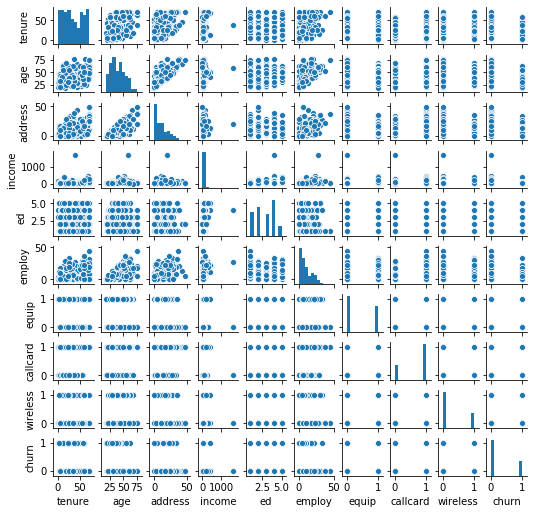

In [7]:
# Let's plot a pair plot of all variables in our dataframe
sns.pairplot(churn_df, size=0.7)

#### Missing value analysis

In [8]:
# Missing value
churn_df.isna().sum()

tenure      0
age         0
address     0
income      0
ed          0
employ      0
equip       0
callcard    0
wireless    0
churn       0
dtype: int64

0.14720209722556957


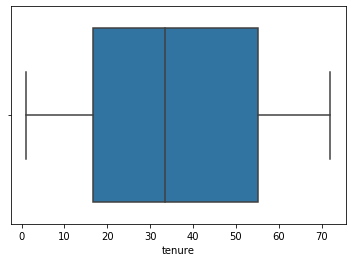

In [9]:
print(churn_df['tenure'].skew())
sns.boxplot(churn_df['tenure']);

0.4794155366413367


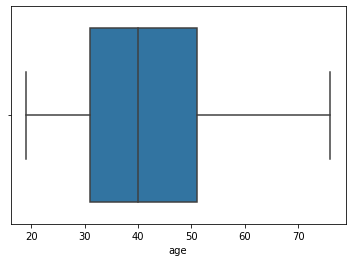

In [10]:
print(churn_df['age'].skew())
sns.boxplot(churn_df['age']);

0.9940767992308749


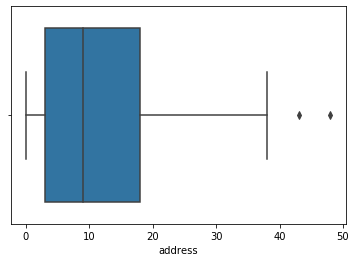

In [11]:
print(churn_df['address'].skew())
sns.boxplot(churn_df['address']);

9.963441075550831


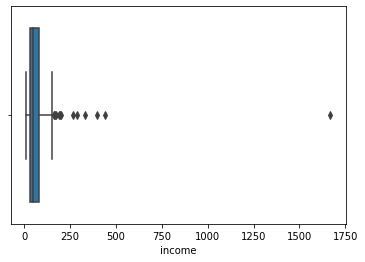

In [12]:
print(churn_df['income'].skew())
sns.boxplot(churn_df['income']);

0.0017470725134808736


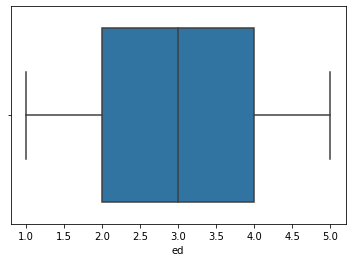

In [13]:
print(churn_df['ed'].skew())
sns.boxplot(churn_df['ed']);

0.9701334510676395


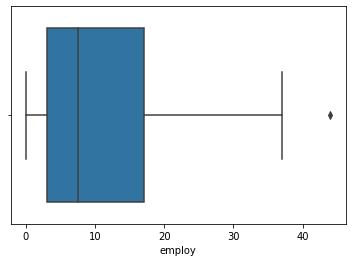

In [14]:
print(churn_df['employ'].skew())
sns.boxplot(churn_df['employ']);

0.30573081741626806


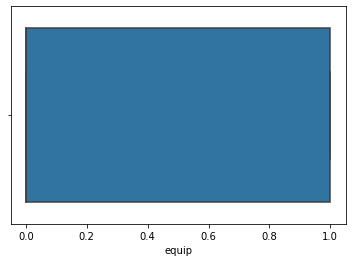

In [15]:
print(churn_df['equip'].skew())
sns.boxplot(churn_df['equip']);

-0.9058465529068497


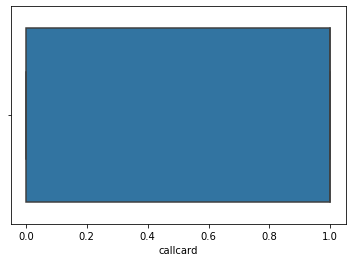

In [16]:
print(churn_df['callcard'].skew())
sns.boxplot(churn_df['callcard']);

0.9326044059104186


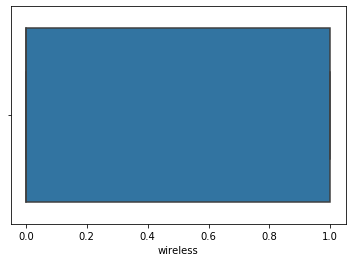

In [17]:
print(churn_df['wireless'].skew())
sns.boxplot(churn_df['wireless']);

In [18]:
# Finding outlier and drop the values
for i in churn_df:
    print(i)
    q75, q25 = np.percentile(churn_df.loc[:,i], [75 ,25])
    iqr = q75 - q25

    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    print(min)
    print(max)
    
    churn_df = churn_df.drop(churn_df[churn_df.loc[:,i] < min].index)
    churn_df = churn_df.drop(churn_df[churn_df.loc[:,i] > max].index)

tenure
-41.0
113.0
age
1.0
81.0
address
-19.5
40.5
income
-41.25
152.75
ed
-1.0
7.0
employ
-15.0
33.0
equip
-1.5
2.5
callcard
-1.5
2.5
wireless
-1.5
2.5
churn
-1.5
2.5


In [19]:
churn_df.shape

(184, 10)

In [20]:
churn_df.isna().sum()

tenure      0
age         0
address     0
income      0
ed          0
employ      0
equip       0
callcard    0
wireless    0
churn       0
dtype: int64

            tenure       age   address    income        ed    employ  \
tenure    1.000000  0.373953  0.417434  0.185197 -0.060506  0.397276   
age       0.373953  1.000000  0.720850  0.309800 -0.058367  0.602133   
address   0.417434  0.720850  1.000000  0.229214 -0.145190  0.535772   
income    0.185197  0.309800  0.229214  1.000000  0.142383  0.508135   
ed       -0.060506 -0.058367 -0.145190  0.142383  1.000000 -0.237967   
employ    0.397276  0.602133  0.535772  0.508135 -0.237967  1.000000   
equip    -0.101031 -0.052544 -0.141645  0.039271  0.487174 -0.198992   
callcard  0.403328  0.148605  0.188384  0.187905 -0.062334  0.278289   
wireless -0.030243 -0.044916 -0.146056 -0.035516  0.257847 -0.106733   
churn    -0.342789 -0.252064 -0.246661 -0.127821  0.202892 -0.311352   

             equip  callcard  wireless     churn  
tenure   -0.101031  0.403328 -0.030243 -0.342789  
age      -0.052544  0.148605 -0.044916 -0.252064  
address  -0.141645  0.188384 -0.146056 -0.246661  
inc

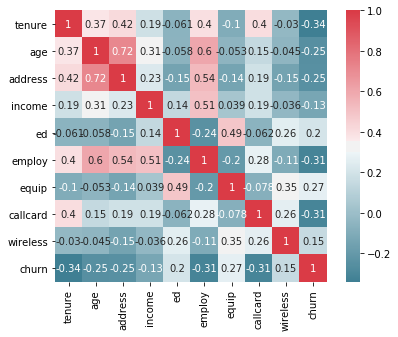

In [21]:
##Correlation analysis

f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = churn_df.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
print(corr)

In [22]:
X = churn_df.drop(['churn'], axis=1)
y = churn_df['churn']
print(X)

     tenure   age  address  income   ed  employ  equip  callcard  wireless
0      11.0  33.0      7.0   136.0  5.0     5.0    0.0       1.0       1.0
1      33.0  33.0     12.0    33.0  2.0     0.0    0.0       0.0       0.0
2      23.0  30.0      9.0    30.0  1.0     2.0    0.0       0.0       0.0
3      38.0  35.0      5.0    76.0  2.0    10.0    1.0       1.0       1.0
4       7.0  35.0     14.0    80.0  2.0    15.0    0.0       1.0       0.0
..      ...   ...      ...     ...  ...     ...    ...       ...       ...
194    57.0  60.0     20.0    14.0  2.0    27.0    0.0       1.0       0.0
195    55.0  44.0     24.0    83.0  1.0    23.0    0.0       1.0       0.0
196    34.0  23.0      3.0    24.0  1.0     7.0    0.0       1.0       0.0
197     6.0  32.0     10.0    47.0  1.0    10.0    0.0       1.0       0.0
198    24.0  30.0      0.0    25.0  4.0     5.0    0.0       1.0       1.0

[184 rows x 9 columns]


##### Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [24]:
X

array([[-1.10589487, -0.55740802, -0.40164782, ..., -0.85781645,
         0.66143783,  1.57216351],
       [-0.05206661, -0.55740802,  0.13465986, ..., -0.85781645,
        -1.51185789, -0.63606615],
       [-0.53107945, -0.79629717, -0.18712475, ..., -0.85781645,
        -1.51185789, -0.63606615],
       ...,
       [-0.00416533, -1.35370519, -0.83069397, ..., -0.85781645,
         0.66143783, -0.63606615],
       [-1.34540129, -0.63703774, -0.07986321, ..., -0.85781645,
         0.66143783, -0.63606615],
       [-0.48317817, -0.79629717, -1.15247858, ..., -0.85781645,
         0.66143783,  1.57216351]])

#### Train/Test dataset

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (147, 9) (147,)
Test set: (37, 9) (37,)


### Logistic Regression Model

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
y_pred = LR.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [28]:
y_pred_prob = LR.predict_proba(X_test)
y_pred_prob

array([[0.44781524, 0.55218476],
       [0.48843056, 0.51156944],
       [0.63406733, 0.36593267],
       [0.49207676, 0.50792324],
       [0.50471017, 0.49528983],
       [0.4922118 , 0.5077882 ],
       [0.68592054, 0.31407946],
       [0.56642895, 0.43357105],
       [0.69944241, 0.30055759],
       [0.46685094, 0.53314906],
       [0.70123979, 0.29876021],
       [0.49110667, 0.50889333],
       [0.62405065, 0.37594935],
       [0.62466335, 0.37533665],
       [0.62067892, 0.37932108],
       [0.53748072, 0.46251928],
       [0.4191453 , 0.5808547 ],
       [0.47407561, 0.52592439],
       [0.36942246, 0.63057754],
       [0.70880011, 0.29119989],
       [0.61185288, 0.38814712],
       [0.70698402, 0.29301598],
       [0.57373445, 0.42626555],
       [0.40142599, 0.59857401],
       [0.6607477 , 0.3392523 ],
       [0.46587891, 0.53412109],
       [0.47681301, 0.52318699],
       [0.65807897, 0.34192103],
       [0.67580496, 0.32419504],
       [0.44186138, 0.55813862],
       [0.

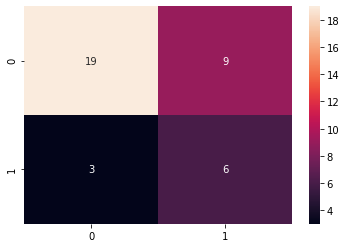

In [34]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
sns.heatmap(cm, annot=True)
plt.show()

In [36]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.40      0.67      0.50         9

    accuracy                           0.68        37
   macro avg       0.63      0.67      0.63        37
weighted avg       0.75      0.68      0.70        37



we can tell the average accuracy for this classifier is the average of the f1-score for both labels, which is 0.72 in our case.

In [37]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_prob)

0.5770631759638292